In [ ]:
% matplotlib inline

# Lab 6. Object detection with Faster-RCNN.

## Objectives 

The main goal of this session is that the student investigates a Convolutional Neural Network with Region Proposal (RCNN) in the context of the object detection task. In other words, over a certain image, we will classify certain objects and their locations based on predefined classes.

Particularly, we will work with Faster-RCNN, the first network to use an automatic strategy for region proposal. We will use part of the PASCAL VOC dataset to conduct our experiments. 

## Delivery

The delivery required for this lab to be evaluated is an executed version of this notebook (all outputs must be visible) with the required implementations and answers. Please use figures and images to properly support and justify your claims. 

__*Please make sure that the results can be visualized before submitting the notebook to AulaGlobal.*__

## References

- [1] Faster-RCNN. https://arxiv.org/abs/1706.05587
- [2] PASCAL VOC 2012 dataset. http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html
- [3] https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection
- [4] https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/
- [5] Fast-RCNN y ROIPooling: https://arxiv.org/abs/1504.08083
- [6] https://en.wikipedia.org/wiki/File:RoI_pooling_animated.gif
- [7] FPN: https://arxiv.org/abs/1612.03144

## Before we begin

Some previous steps need to be taken for the use of Google Colaboratory. The material of the lab needs to be unzipped into the Google Drive directory where this notebook is located. The name of this directory needs to be `objdetection`. Once this is done, the following code needs to be run after properly specifying the path to the directory (variable `path`):

In [ ]:
# #Descomenta únicamente si quieres ejecutar este código en Google Colab
from google.colab import drive
import os, sys
drive.mount('/content/drive')
print(os.getcwd())
path = '/content/drive/My Drive/Colab Notebooks/Object-Detection' # <-- Full path prefix to objdetection dir
os.chdir(path) 
sys.path.append(path) 

# Ignore warnings (when debugging, comment the next two lines)
import warnings
warnings.filterwarnings("ignore")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


Additionally, to run the code in a GPU environment (recommended) go to `Entorno de ejecución->Cambiar tipo entorno de ejecución` and choose GPU in `acelerador por hardware`.

## Part 1. Theory.

Before we learn how a Faster RCNN is implemented, let us remember some key aspects from the theory.

### Object detection

In object detection, an object is defined with respect to a _bounding box_, which completely surounds the object. The bounding box is defined with respect to its location (usually its center or top-left coordinate) and its size (width and length). This means that 4 numbers are required to do so (see image below). 

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/cs.PNG">

Each object will also have an associated label depending on which predefined category it belongs to.

### Faster-RCNN

This section will focus on some key concepts regarding Faster-RCNNs. However, it is highly recommended to review the original paper [1] and the course slides that explain them.

Faster-RCNN is a _framework_ that adapts a classification-oriented CNN to object detection. To do so, a _backbone_ is used consisting on the feature extraction layers of a pre-trained CNN. From this, two blocks are used in conjunction in order to simultaneously obtain the object location and its associated class. These blocks are a Region Proposal Network (RPN) and a *RoI pooling* block for posterior classification (see image below).

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/faster.JPEG">

Thus, Faster RCNNs use a convolutional feature map in which both the bounding boxes and the defining features are to be found. This feature map does not have to be the same size of the image, since strides could happen during intermediate layers. For instance, if the size of the input image is H x W, the feature map could be H/16 x W/16. 


#### Region Proposal Network (RPN)

The main goal of this block is to obtain the parts of the image (or rather, of the feature maps) that are susceptible to contain an object. Therefore, in each location of the map we consider _k_ _anchors_ (potential center of objects). Typically, _k_=9 (3 sizes: 128, 256 y 512 pixels; and 3 aspect ratios 1:1, 1:2 y 2:1). An example of the anchors' locations and their representations can be seen in the images below.

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/anchor_centers.png">

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/anchors-progress.png">

From the amount of available anchors ($k \cdot H/16 \cdot W/16$), only some match the actual position and shape opf the objects in the image. In order to find which of these anchors are correct, we define a loss function $L_{objectness}$ which trains the probability of an anchor being correct with respect to IoU - _Intersection over Union_ -. Anchors with a high IoU are labeled positive while anchors with a los one are labeled negative (anchors with ambiguous values of IoU do not contribute to the training stage). See [1] for more details.

The sizes and shapes of the anchors, however, are limited and, hence, insufficient to represent the object's shape. Thus, for the positive anchors with highest objectness score, the bounding box is then adjusted through a regression loss function $L_{reg}$ (which considers the difference between the real bounding box and the anchors'). Therefore, the bounding box finally predicted by the RPN can be seen as a slight deviation from the anchor.

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/reg.PNG">

Then, $L_{objectness}$ finds the best anchors to represent the obejcts in the image while $L_{reg}$ adapts those anchors to the true shape of the object. 



#### _RoI pooling_ and classification

Until now, obejcts have defined agonstically (without considering their category). Once the objects have been located, we need to determine their category. To do this, we could feed the feature map chunks bounded by the identified boxes to a final set of fully-connected layers. however, this would require all chunks to be the same size, which is almost certainly always false. To solve this, we use a RoI pooling strategy, which adapts the features map to a fixed size.

This strategy simply consists on defining a grid over the feature map's bounding box which will be used to pool values from. The bounding box's size is $H_{bb}$ x $W_{bb}$, so if we set the grid to be $H_{fix}$ x $W_{fix}$ with each cell of the grid being size $H_{bb}/H_{fix}$ x $W_{bb}/W_{fix}$, we can apply a max pooling from each cell to obtain an adapted, fixed sized version of the feature map. This can be seen in the animation below.

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/RoI_pooling_animated.gif">

Once the fixed sized regions are set, we can use the network to classify the objects according to teheir category. This is done through a loss function $L_{cls}$. Additionally, the bounding boxes are refined with the newly obtained information (from RoI pooling and class definition) with a new regressive loss function $L_{reg2}$. An example of object detection for a certain input image is shown below (bounding box + object class with associated likelyhood).

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/result.PNG">


### Additional information for this lab: FPN 

For object detection networks, detection at different scales is challenging (particularly for small objects). The traditional strategy for this is the construction of a pyramid for the image at different scales (see the figure below), and the application of the same detection procedure for the different scales. However, in the case of neural networks, the processing of different versions of the same image requires memory and time. However, this multiscale processing can be applied to the high-level characteristics of some layer of the network (already processed), which is more efficient (in addition, its spatial dimension is smaller).

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/pyramid.jpeg">

Note that feature maps near the input are not useful for especially large object detection, as they are composed of low-level structures (edges) of the image. For this reason, frequently, prior to an RPN, a * Feature Pyramid Network * (FPN) is applied, a feature extractor that generates feature maps of different sizes (multiscale) with different information for each scale, like the figure below shows.

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/fpn.png">

On each of these feature maps, the RPN proposes the *anchors*. Specifically, depending on the spatial resolution of each feature map, the RPN uses different translation-invariant *anchors*: the RPN proposes the smallest-size translation-invariant *anchors* on the higher-resolution feature map and the largest translation-invariant *anchors* over the lower resolution map locations. This makes sense from a logical point of view: on maps with more low-level information, the small *anchors* are placed to search for small objects, and on maps with high-level information, the larger *anchors* are placed, which look for objects that make up a large percentage of the image area.

For more detailed information, see [7].

### Evaluation

The performance of the detection system is analyzed in terms of the F1 score. However, to define this measure, you must first define the precision and the  recall. Each of these measures are defined below.

The __precision__, for the case of object detection, represents the percentage of correctly detected objects out of the total number of detected objects (correct and incorrect). It is calculated as:

\begin{equation}
P=\frac{TP}{TP+FP},
\end{equation}

where $TP$ is the number of *true positives* (correctly identified objects) and $FP$ the number of *false positives* (incorrectly identified objects).

The __ * recall * __ represents the percentage of correctly detected objects out of the total number of objects present in the images. It is calculated as:


\begin{equation}
R=\frac{TP}{TP+FN},
\end{equation}

where $ FN $ represents the number of * false negatives * (objects present in the images but not detected).

Nevertheless, the network provides a series of *bounding boxes* on the image that can coincide to a greater or lesser extent with the *ground truth*. Thus, you have to establish a __criterion to consider a prediction as correct__. This is usually established in the quality of segmentation, by means of the *Intersection over Union*, __IoU__ measure, also called *Jaccard Index* (JI). The $ IoU $ measures the similarity between two regions $A$ and $B$ as:

\begin{equation}
IoU=\frac{A \cap B}{A \cup B}
\end{equation}

where $\cap$ is the intersection between the regions (area in common) and $\cup$ is the union or total area that they cover between them. A minimum threshold of $IoU_{th} = 0.5 $ or $ IoU_ {th} = 0.7$ is usually set to consider a detection as correct. An example of the $ IoU $ measure on *bounding boxes* can be seen below (it will be used in our object detection architecture).

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/iou.png" width="500 pix">

Similarly, the $IoU$ measure can be used to set quality in object instance segmentation.

Finally, once these measures have been described, the F1 score can be defined. The F1-*score* considers both the precision and the recall to obtain a weighted harmonic mean between them such that:

\begin{equation}
F1=2\cdot \frac{P\cdot R}{P+R},
\end{equation}

Therefore, this measure summarizes in a single figure the performance of our object detector for a given __point of operation__. The network provides a series of *bounding boxes* with an associated __*score*__, which indicates how likely it is that an object of a certain class exists in that region. However, the precision, the recall and the F1 measure do not take this *score* into account for the calculation, and these measures will depend on the __operation point__ chosen for the system: frequently, those regions with a *low score* (e.g., $score<0.5$) are discarded.

### Data

The database that will be used in practice is a subset of the PASCAL VOC 2012 database [2]. This database contains images with various objects belonging to 20 categories:

- __Person__: _person_
- __Animal__: _bird, cat, cow, dog, horse, sheep_
- __Vehicle__: _aeroplane, bicycle, boat, bus, car, motorbike, train_
- __Indoor__: _bottle, chair, dining table, potted plant, sofa, tv/monitor_

During this session you are going to work on the set __Indoor__. Specifically, objects of the classes: _bottle, chair_ and _dining table_ will be detected. The images are provided in separate folders for training and testing. The sets are distributed as follows:
- Training: 234 images, in which there are 90 objects of the *bottle* class, 125 of the *chair* class, 36 of the *dining table* class and 40 of the *sofa* class.
- Test: 68 images, in which there are 36 objects of the *bottle* class, 52 of the *chair* class and 15 of the *dining table* class and 27 of the *sofa* class.

## Part 2. Implementation.

First, we import the necessary libraries

In [ ]:
import os
import time
import csv
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile, ImageDraw
import cv2
import random

# Set random seed for replicability (MANUALLY)
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch uses some non-deterministic algorithms
torch.backends.cudnn.enabled = False

Random Seed:  999


### Runtime input variables

Some inputs are defined:

- **data_dir** - the root directory of the database, described later.
- **num_workers** - the number of threads to load the data with the DataLoader class.
- **batch_size** - the size of the _batch_.
- **num_classes** - the number of classes to detect.
- **class_names** - the names of the classes to detect.
- **num_epochs** - number of _epochs_ for network training.
- **step_size** - number of _epochs_ after which the learning rate is reduced by a factor of 0.1.
- **lr** - initial learning rate.
- **device** - the device (GPU or CPU) for execution.

In [ ]:
data_dir = "myVOC4"
num_workers = 2  # to debug, fix num_workers=0
batch_size = 1  # Training and test (if we use 1 we don't need to resize the images)
num_classes = 5  # Number of classes
class_names = ['background', 'bottle', 'chair', 'dining_table', 'sofa']
num_epochs = 4
step_size = 5
lr = 0.001
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Modified library 

For this session, a modified version of the torchvision library will be used, which we will name torchvision_05. This modified version allows to train our detection network with images that do not contain any objects, whereas the original version does not allow it. Likewise, it provides us with the information of the _anchors_ selected for each object during the inference. We import the necessary modules

In [ ]:
import torchvision_05
from torchvision_05.models.detection.rpn import AnchorGenerator
from torchvision_05.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision_05.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.transforms.functional as F

### Network

The network to be used will be a version of Faster-RCNN on ResNet-50. Specifically, the first 4 blocks of this network are used, composed of convolutional layers, batch normalization (whose parameters are frozen) and non-linear layers. We also add a FPN, _Feature Pyramid Network_, which extracts characteristics from the resulting maps of the network at different scales. After this *backbone*, Faster-RCNN's own modules are placed: the region proposition network and the _RoI pooling_ and classification.

The following is the function that builds the network.

In [ ]:
def get_model_detection(num_classes, device):
    # load a Faster RCNN model pre-trained on COCO
    model = torchvision_05.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model = model.to(device) # Send the model to GPU
    return model

In the next cell, we will load the model, please stop to analyze each of the layers that define the model and its characteristics.

In [ ]:
model_ft = get_model_detection(num_classes, device)
print(model_ft)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False

### Database

The function to load the database is defined below. To simplify its treatment, the database is provided in the form of images (`images`) and masks for each of the object instances (` instances`). Thus, for each image there are as many masks as there are objects in it (with the segmentation of each one of them). Also, the category of each object is encoded in the name of the image. In addition, the `classes` semantic segmentation and the `masks` instance segmentation are provided.

Try to understand the return variables of this function.

**IMPORTANT**: input images are not normalized. The _framework_ itself performs normalization internally with the mean of ImageNet samples.

In [ ]:

class VOCDataset(object):
    def __init__(self, root, train):
        self.root = root
        self.train = train
        # load all image files, sorting them to
        # ensure that they are aligned
        if self.train:
            self.imgs = [os.path.join(root, name)
                         for root, dirs, files in os.walk(root)
                         for name in files if ('train' + os.path.sep + 'images' in root)
                         if name.lower().endswith(".jpg")]
        else:
            self.imgs = [os.path.join(root, name)
                         for root, dirs, files in os.walk(root)
                         for name in files if ('test' + os.path.sep + 'images' in root)
                         if name.lower().endswith(".jpg")]

    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.imgs[idx]
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        img = Image.open(img_path).convert("RGB")

        # Independent annotations for each object
        file = self.imgs[idx].split(os.path.sep)[-1]
        self.masks = [os.path.join(self.root, name)
                      for self.root, dirs, files in
                      os.walk(self.imgs[idx].replace('images', 'instances').replace(file, ''))
                      for name in files
                      if (name.startswith(file[:-4] + '_'))]
        if not self.masks:
            masks = np.array(Image.new('L', img.size))
            labels = np.zeros((0,), dtype=np.int64)
            num_objs = 0
        else:
            mask = np.zeros((len(self.masks), img.size[1], img.size[0]), dtype=np.uint8)
            labels = np.zeros((len(self.masks),), dtype=np.int64)
            for j in range(len(self.masks)):
                mask[j, :, :] = np.array(Image.open(self.masks[j]))
                labels[j] = int(self.masks[j].split('_')[-1][:-4])
            num_objs = len(mask)
            masks = np.asarray(mask)

        boxes = []

        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            # Get aspect ratio
            W = xmax - xmin
            H = ymax - ymin
            if W == 0 or H == 0:
                labels = np.delete(labels, i)
            else:
                boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs = boxes.size(0)
        # get the labels
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        # We need the area to filter the empty images
        if not boxes.size() == torch.Size([0]):
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([0.])

        target = {"boxes": boxes, "labels": labels, "image_id": image_id, "area": area}

        img = F.to_tensor(img)
        return img, target, img_path

    def __len__(self):
        return len(self.imgs)

We use the previously defined function to load the data. 

In [ ]:
import utils


def create_datasets(data_dir):
    # use our dataset and defined transformations
    dataset = VOCDataset(data_dir, train=True)
    dataset_test = VOCDataset(data_dir, train=False)

    return dataset, dataset_test


def create_dataloaders(dataset, dataset_test, batch_size, num_workers):
    # define training and test data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,  # to debug, fix num_workers=0
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers,
        collate_fn=utils.collate_fn)
    
    return data_loader, data_loader_test

### Evaluation metrics

Likewise, the function that tests the quality of our model is defined in terms of object detection (precision and recall) and classification (among the detected objects, which ones are correctly classified according to their category).
The function receives as parameters:
- __model__: the CNN to evaluate.
- __dataloader__: the loader of the test data.
- __class_names__: names of the object classes to detect (always include the *background* class first).
- __th_score__: the network provides each detected object with a probability between 0 and 1. This threshold discards objects with objectness such that $Pr(object)<score_{th}$.
- __th_iou__: imposes a minimum IoU threshold from which to consider a detection as correct, that is, it is a decision on how to evaluate the system.
- __result_dir__: path to the results directory.
- __SAVE_OPT__: to save or not the test results as images with the * ground truth *, the predicted * bounding boxes * and the corresponding * anchors *.
- __SAVE_FULL__: to save the total results on each image (True) or save them in different folders for each size of * anchor * for later analysis (False).
- __VERBOSE__: prints on screen the total evaluation measures (without taking into account each class) if it is False, or the totals and marginals for each class if it is True.
- __batchsize__: must be equal to 1.

The function provides as outputs:
- __precision_RPN__ - Precision for object detection of the RPN.
- __recall_RPN__: the recall for the detection of RPN objects.
- __f1_score_RPN__: the F1 score for detection, which we take as the main measure of system performance.
- __cm_global__: confusion matrix between classes for classification.
- __prec_rec_global__: precision and recall for the classification in general.
- __prec_rec_marginal__: precision and recall for the classification of each particular class.
- __total_anchors__: all the anchors of the network for the test set, for further analysis.
- __total_labels__: labels of said anchors.

__IMPORTANT:__ It should be noted that the inference function returns the evaluation measures for both the RPN (`precision_RPN`,` recall_RPN` and `f1_score_RPN`), that is, these measures refer to the *objectness* or ability to detect objects from the network regardless of its category; and the final classification of the network (`cm_global`,` prec_rec_global` and `prec_rec_marginal`), which refer to how efficient the network is in classifying the outputs of the RPN according to their category.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, average_precision_score
from sklearn.preprocessing import LabelBinarizer

# Auxiliary function to compute the intersection over union between 2 bounding boxes
from external import bb_intersection_over_union


def test_detection_model(model, dataloader, class_names, th_score, th_iou, result_dir,
                         SAVE_OPT=False, SAVE_FULL=False, VERBOSE=False,
                         batch_size=1):
    since = time.time()
    # Standard values for anchors and image size
    bins = [48, 96, 192, 384]
    size_anchors = [32, 64, 128, 256, 512]
    min_size = 800
    max_size = 1333
    model.eval()  # Set model to evaluate mode

    # Detection measurements
    ret = 0
    rel = np.zeros((len(class_names) - 1,), dtype=int)
    ret_rel = np.zeros((len(class_names) - 1), dtype=int)

    # Classification measurements
    y_true = np.zeros((0,), dtype='int')
    y_pred = np.zeros((0,), dtype='int')
    y_score = np.zeros((0,), dtype='int')
    batch_counter = 0
    total_anchors = np.zeros((0, 4), dtype='float32')
    total_labels = np.zeros((0,), dtype=int)
    
    print('\nEvaluating...')
    with torch.no_grad():
        # Iterate over data.
        for inputs, targets, paths in dataloader:
            batch_counter = batch_counter + 1
            inputs = list(image.to(device) for image in inputs)
            labels = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Scale factor (useful for anchor extraction)
            size_img = inputs[0].size()[1:]
            scale_factor = min_size / min(size_img)
            if max(size_img) * scale_factor > max_size:
                scale_factor = max_size / max(size_img)
            
            # Let's create the ground-truth boxes and labels
            if np.array(labels[0]['boxes'].cpu()).shape[0] == 0:
                gt_boxes = np.zeros((0, 4), dtype='float32')
            else:
                gt_boxes = np.array(labels[0]['boxes'].detach().cpu())
                gt_labels = np.array(labels[0]['labels'].detach().cpu())
                # Relevant objects per class
                for j in range(1, len(class_names)):
                    rel[j - 1] = rel[j - 1] + np.sum(gt_labels == j)

            # Prediction: returns boxes, scores (objectness), labels (class) and anchors
            pred = model(inputs)
            pred[0]['scores'] = pred[0]['scores'].detach().cpu()
            pred[0]['boxes'] = pred[0]['boxes'].detach().cpu()
            pred[0]['labels'] = pred[0]['labels'].detach().cpu()
            pred[0]['anchors'] = pred[0]['anchors'].detach().cpu()
            # We use only those with scores>th_score and convert them to numpy arrays
            if len(pred[0]['scores'].numpy()) == 0:
                pred_boxes = np.zeros((0, 4), dtype='float32')
                pred_labels = np.zeros((0,), dtype=int)
            else:
                pred_score = list(pred[0]['scores'].numpy())
                if pred_score[0] > th_score:
                    pred_t = [pred_score.index(x) for x in pred_score if x > th_score][-1]
                    pred_class = [class_names[i] for i in list(pred[0]['labels'].numpy())]
                    pred_labels = pred[0]['labels'].numpy()
                    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(pred[0]['boxes'].numpy())]
                    pred_boxes = np.array(pred_boxes[:pred_t + 1])
                    pred_anchors = [[i[0], i[1], i[2], i[3]] for i in list(pred[0]['anchors'].numpy())]
                    pred_anchors = np.array(pred_anchors[:pred_t + 1])
                    total_anchors = np.concatenate((total_anchors, pred_anchors), axis=0)
                    pred_class = pred_class[:pred_t + 1]
                    pred_labels = pred_labels[:pred_t + 1]
                    total_labels = np.concatenate((total_labels, pred_labels), axis=0)
                else:
                    pred_boxes = np.zeros((0, 4), dtype='float32')
                    pred_labels = np.zeros((0,), dtype=int)

            # Retrieved objects 
            ret = ret + len(pred_labels)

            # Detection statistics: we compute the intersection over union between the ground-truth objects
            # and the retrieved ones, if it exceed th_iou, the detection is considered as a good one
            for j in range(gt_boxes.shape[0]):
                ious = np.zeros((pred_boxes.shape[0],), dtype='float')
                for k in range(pred_boxes.shape[0]):
                    ious[k] = bb_intersection_over_union(gt_boxes[j, :], pred_boxes[k, :])
                if len(ious) > 0:
                    iou_max = np.max(ious)
                    pos = np.argmax(ious)
                    if iou_max > th_iou:
                        ret_rel[gt_labels[j] - 1] += 1
                        y_true = np.concatenate((y_true, gt_labels[j][np.newaxis]), axis=0)
                        y_pred = np.concatenate((y_pred, pred_labels[pos][np.newaxis]), axis=0)

            # Save the images with detections and ground-truth objects in a new folder, to analyze the results
            if SAVE_OPT and SAVE_FULL:
                aux = paths[0].split('/')
                folder_path = os.path.join(result_dir, 'instances_pred_full')
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                    
                img = np.array(F.to_pil_image(inputs[0].cpu()))
                for i in range(pred_boxes.shape[0]):
                    cv2.rectangle(img, (pred_boxes[i][0], pred_boxes[i][1]), (pred_boxes[i][2], pred_boxes[i][3]),
                                  color=(255, 0, 0), thickness=1)
                    cv2.putText(img, pred_class[i], (pred_boxes[i][0], pred_boxes[i][1]), cv2.FONT_HERSHEY_SIMPLEX, 1,
                                (255, 255, 255), thickness=1)
                    
                for i in range(gt_boxes.shape[0]):
                    cv2.rectangle(img, (gt_boxes[i][0], gt_boxes[i][1]), (gt_boxes[i][2], gt_boxes[i][3]),
                                  color=(0, 255, 0), thickness=1)
                    cv2.putText(img, class_names[gt_labels[i]], (gt_boxes[i][0], gt_boxes[i][1]),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness=1)
                    
                pred_path = folder_path + '/' + aux[-1]
                cv2.imwrite(pred_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            
            elif SAVE_OPT and not SAVE_FULL:
                aux = paths[0].split('/')
                folder_path = os.path.join(result_dir, 'instances_pred')
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                    
                for i in range(pred_boxes.shape[0]):
                    anchor_size = size_anchors[np.digitize(
                        np.sqrt((pred_anchors[i, 2] - pred_anchors[i, 0]) * (pred_anchors[i, 3] - pred_anchors[i, 1])),
                        bins)]
                    img = np.array(F.to_pil_image(inputs[0].cpu()))
                    cv2.rectangle(img, (pred_boxes[i][0], pred_boxes[i][1]), (pred_boxes[i][2], pred_boxes[i][3]),
                                  color=(255, 0, 0), thickness=1)
                    cv2.rectangle(img, (int(pred_anchors[i][0] / scale_factor), int(pred_anchors[i][1] / scale_factor)),
                                  (int(pred_anchors[i][2] / scale_factor), int(pred_anchors[i][3] / scale_factor)),
                                  color=(0, 0, 255), thickness=1)
                    cv2.putText(img, pred_class[i], (pred_boxes[i][0], pred_boxes[i][1]), cv2.FONT_HERSHEY_SIMPLEX, 1,
                                (255, 255, 255), thickness=1)
                    
                    for j in range(gt_boxes.shape[0]):
                        cv2.rectangle(img, (gt_boxes[j][0], gt_boxes[j][1]), (gt_boxes[j][2], gt_boxes[j][3]),
                                      color=(0, 255, 0), thickness=1)
                        cv2.putText(img, class_names[gt_labels[j]], (gt_boxes[j][0], gt_boxes[j][1]),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness=1)
                    
                    img_path = os.path.join(folder_path, str(anchor_size))
                    if not os.path.exists(img_path):
                        os.makedirs(img_path)
                        
                    pred_path = f'{folder_path}/{anchor_size}/{aux[-1][:-4]}_{i}.png'
                    cv2.imwrite(pred_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

            torch.cuda.empty_cache()

    # Detection statistics: precision and recall per class
    precision_RPN = 0
    if ret > 0:
        precision_RPN = np.sum(ret_rel) / ret
        
    recall_RPN = np.zeros((rel.size,), dtype='float32')
    for j in range(rel.size):
        if rel[j] > 0:
            recall_RPN[j] = ret_rel[j] / rel[j]
        else:
            recall_RPN[j] = 0

    # F1 score(weighted mean of precision and recall)
    if np.mean(recall_RPN) == 0 or precision_RPN == 0:
        f1_score_RPN = 0
    else:
        f1_score_RPN = 2 * np.mean(recall_RPN) * precision_RPN / (np.mean(recall_RPN) + precision_RPN)

    # Classification statistics: precision and recall
    prec_rec_marginal = precision_recall_fscore_support(y_true, y_pred, average=None,
                                                        labels=[f for f in range(1, len(class_names))], zero_division=0)
    prec_rec_global = precision_recall_fscore_support(y_true, y_pred, average='macro',
                                                      labels=[f for f in range(1, len(class_names))], zero_division=0)
    # Confusion matrix
    cm_global = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
    
    time_elapsed = time.time() - since
    print(f'Evaluation complete in {int(time_elapsed // 60)}m {time_elapsed % 60}s')
    print(f'Objectness-RPN. F1: {f1_score_RPN}.     Precision: {precision_RPN}. Recall: {np.mean(recall_RPN)}')
    
    if VERBOSE:
        for i in range(1, len(class_names)):
            print(f'Class: {class_names[i]}. Recall: {ret_rel[i - 1]}/{rel[i - 1]}')
        print('')
    if prec_rec_global[0] + prec_rec_global[1] > 0:
        f1_class_global = 2 * prec_rec_global[0] * prec_rec_global[1] / (prec_rec_global[0] + prec_rec_global[1])
    else:
        f1_class_global = 0

    print(f'Global classification: F1: {f1_class_global}.     Precision: {prec_rec_global[0]}. Recall: {prec_rec_global[1]}')
    
    if VERBOSE:
        for i in range(1, len(class_names)):
            if (prec_rec_marginal[0][i - 1] + prec_rec_marginal[1][i - 1]) > 0:
                f1_class = 2 * prec_rec_marginal[0][i - 1] * prec_rec_marginal[1][i - 1] / (
                        prec_rec_marginal[0][i - 1] + prec_rec_marginal[1][i - 1])
            else:
                f1_class = 0
            
            print(f'Class: {class_names[i]} F1: {f1_class}.     Precision: {prec_rec_marginal[0][i - 1]}. Recall: {prec_rec_marginal[1][i - 1]}')
    
    return {
        'precision': precision_RPN,
        'recall': recall_RPN,
        'f1_class': f1_class_global,
        'f1_score': f1_score_RPN,
        'cm': cm_global,
        'prec_rec_global': prec_rec_global,
        'prec_rec_marginal': prec_rec_marginal,
        'anchors': total_anchors,
        'l_t': total_labels
    }

### Training

Training is performed during $n_e$ epochs, reducing the training error rate as training progresses. The code produces a file called _log.csv_ where the variation of the loss functions in each training _epoch_ can be analyzed, as well as the corresponding precision and recall in the test set for both detection and classification. Check that the loss functions decrease (approximately) monotonously, and that the test measures stagnate as the training progresses (and become louder).

__IMPORTANT:__ the best _epoch_ of the network is considered as the one that provides the best F1-score measure (harmonic mean of precision and recall) and its weights are stored.

In [ ]:
from engine import train_one_epoch, eval_one_epoch

def train_model(model_ft, batch_size, num_epochs,
                obj_thresh=0.5, iou_thresh=0.5,
                save_every=5, save_best_f1=True,
                result_dir='baseline_results'):
  
    # We create the baseline folder
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    # Weights for L_objectiveness, L_reg, L_cls y L_reg2
    weights = [1, 1, 1, 1]

    # Training
    params = [p for p in model_ft.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)  # construct an optimizer
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

    # CSV file for training results
    log_path = os.path.join(result_dir, 'log.csv')
    if os.path.exists(log_path):
        os.remove(log_path)

    with open(os.path.join(log_path), 'w') as csv_file:
        coord_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        coord_writer.writerow(['Train total', 'Train rpn_box_reg', 'Train objectness', 'Train box_reg', 'Train classifier',
                               'Val total', 'Val rpn_box_reg', 'Val objectness', 'Val box_reg', 'Val classifier'])
      
    # info based on obj thresh and iou thresh
    info = f'obj{str(obj_thresh).replace(".", "-")}_iou{str(iou_thresh).replace(".", "-")}'  # i.e. obj0-5_iou0-5

    last_epoch = get_last_epoch(result_dir, f'f-rcnn_{info}', num_epochs)  # 0 if no checkpoint is found

    best_f1 = -0.0001
    for epoch in range(last_epoch, num_epochs):
        print(f"\nEpoch: {epoch + 1}/{num_epochs}")

        model_path = os.path.join(result_dir, f'f-rcnn_{info}_e{epoch}.pth')  # i.e. f-rcnn_obj0-5_iou0-5_e10.pth
        
        if not os.path.exists(model_path):
            # train for one epoch, printing every epoch
            train_aux_losses = train_one_epoch(model_ft, optimizer, data_loader, device, weights, epoch, print_freq=250)
            # Update the learning rate
            lr_scheduler.step()
            # Validation
            val_aux_losses = eval_one_epoch(model_ft, data_loader_test, device, epoch, print_freq=250)
            print(val_aux_losses)
            # Evaluation
            results = test_detection_model(model_ft, data_loader_test,
                                                class_names, obj_thresh, iou_thresh,
                                                result_dir, False, False, False,
                                                batch_size=batch_size)
            # Save best model based on f1 score
            if save_best_f1:
                f1_score = results['f1_score']
                if f1_score > best_f1:
                    torch.save(state, os.path.join(result_dir, f'best_model_{info}_e{epoch}.pth'))
                    best_f1 = f1_score
            
            # Save model every N epochs
            if epoch % save_every == 0:
                # Save the state and the model with best AP-score for inference
                state = {'epoch': epoch + 1, 'state_dict': model_ft.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': lr_scheduler.state_dict(), }
                torch.save(state, model_path)
            
            # Save the losses
            write_log(log_path, train_aux_losses, val_aux_losses)
              
        else:
            # Load this epoch information to resume training
            print(f"=> loading checkpoint '{epoch}'")
            checkpoint = torch.load(model_path)
            lr_scheduler.load_state_dict(checkpoint['scheduler'])
            model_ft.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print(f"=> loaded checkpoint '{epoch}'")

If the execution is halted mid-training for any reason, make sure to close the csv file that was opened (uncomment following cell).

In [ ]:
import glob

def get_last_epoch(result_dir, file, total_epochs):
    models = glob.glob(f'{result_dir}/{file}*')
    if not models:
        return 0
    
    epochs = [int(model.split('.')[0].split('_')[-1][1:]) for model in models]
    epoch_no = list(filter(lambda x: x <= total_epochs, epochs))[-1]

    return epoch_no

In [ ]:
def write_log(log_path, train_aux_losses, val_aux_losses):
    with open(os.path.join(log_path), 'a') as csv_file:
        coord_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        coord_writer.writerow(
            [str(train_aux_losses['total']), str(train_aux_losses['rpn_box_reg']), str(train_aux_losses['objectness']),
            str(train_aux_losses['box_reg']), str(train_aux_losses['classifier']),
            str(val_aux_losses['total']), str(val_aux_losses['rpn_box_reg']), str(val_aux_losses['objectness']),
            str(val_aux_losses['box_reg']), str(val_aux_losses['classifier'])])
        
        # ['Train total', 'Train rpn_box_reg', 'Train objectness',
        #  'Train box_reg', 'Train classifier',
        #  'Val total', 'Val rpn_box_reg', 'Val objectness',
        #  'Val box_reg', 'Val classifier']

### Evaluation

After training the network, the results for the test set will be obtained. First, the weights of the trained network are loaded into the model and the evaluation function is called. Pay attention to the parameters that the function receives.

Analyze the information that the function returns. Notice the difference between the measures of *objectness* on the RPN and the system's final detected object classification measures.

In [ ]:
# # Inference
# model_weights = torch.load(os.path.join(result_dir,'best_model.pth'.format(num_epochs-1)))['state_dict']
# model_ft.load_state_dict(model_weights)
# _ = test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, True, False, True)

## Part 3. Experiments.

This section will contain the experiments and analysis implemented by the student. These, along with the answers to the questions proposed during the section, will be used to evaluate the student's knowledge on the topic of object detection and, therefore, will determine their grade for this laboratory.

Note that implementation answers should be provided in the empty code cells whereas textual justification should be written in the empty text cells. You can generate additional cells (both text and code) if you deem it necessary. 

In [ ]:
def load_model(path):
    model_weights = torch.load(path)['state_dict']
    model_ft.load_state_dict(model_weights)
    return model_ft

In [ ]:
result_dir = 'baseline_results'

In [ ]:
dataset, dataset_test = create_datasets(data_dir)
data_loader, data_loader_test = create_dataloaders(dataset, dataset_test, batch_size, num_workers=8)

### 1. Training process.

Think on the input variables defined at the beginning of the notebook. How many epochs have we defined for the training process? Do you think this number is enough? Justify your answer.

> We think 4 epochs is not enough. The optimal way, as we will do later, should be plotting the training and validation loss and analyzing how they progress and relate to each other over epochs. However, for an a priori answer, we simply take a look at our model. While it is not a massive model, we believe that it is large enough, in size, and diverse enough, that the complexity to be able to learn or express would require a high training time, and we consider 4 epochs to be insufficient for this. 

Increase the number of epochs until the model reaches a F1 score in the testing process reaches a value of $F1>0.9$. Note that the after training the net, the weights of the model are stored, so additional epochs can be added without the need for trainig the whole system again.

You can also try altering other training parameters (e.g. IoU and objectness threshold), but note that this will alter the training process, so tread carefully. 

In [ ]:
# num_epochs = 25
# model_ft = get_model_detection(num_classes, device)

# train_model(model_ft, batch_size, num_epochs=num_epochs,
#             obj_thresh=0.5, iou_thresh=0.5,
#             save_every=1, save_best_f1=False, result_dir='baseline_results')


Epoch: 1/25
(TRAIN) Epoch: [0]  [233/234]  eta: 0:00:00  lr: 0.001000  loss: 0.6000 (1.3363)  loss_classifier: 0.0435 (0.2183)  loss_box_reg: 0.0282 (0.0764)  loss_objectness: 0.5372 (0.9285)  loss_rpn_box_reg: 0.0182 (0.1131)  time: 0.3059  data: 0.0025  max mem: 5385
(TRAIN) Epoch: [0] Total time: 0:01:14 (0.3190 s / it)
(VAL) Epoch: [0]  [67/68]  eta: 0:00:00  loss: 0.3448 (0.5051)  loss_classifier: 0.1085 (0.1246)  loss_box_reg: 0.0910 (0.1049)  loss_objectness: 0.1185 (0.2608)  loss_rpn_box_reg: 0.0097 (0.0147)  time: 0.1092  data: 0.0027  max mem: 5385
(VAL) Epoch: [0] Total time: 0:00:08 (0.1190 s / it)

Evaluating...
Evaluation complete in 0.0m 10.157198905944824s
Objectness-RPN. F1: 0.3756683334816954.     Precision: 0.7090909090909091. Recall: 0.25551995635032654
Global classification: F1: 0.45098039215686275.     Precision: 0.4107142857142857. Recall: 0.5

Epoch: 2/25
(TRAIN) Epoch: [1]  [233/234]  eta: 0:00:00  lr: 0.001000  loss: 0.2557 (0.4950)  loss_classifier: 0.0839 (

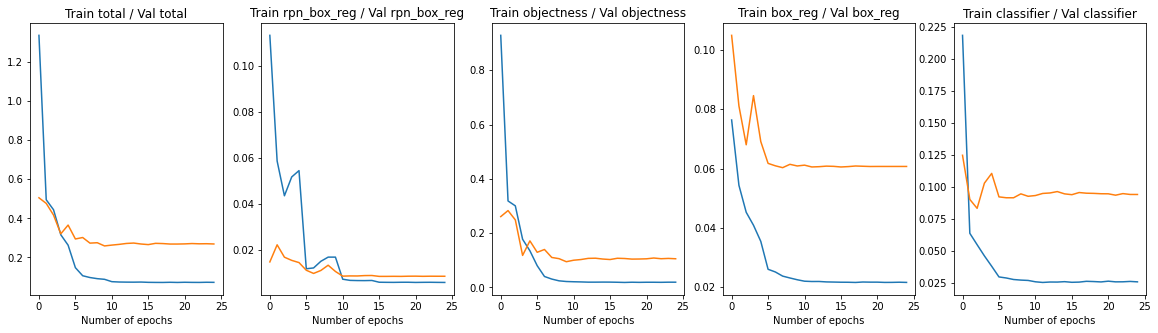

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 

def draw_metrics(log_path):
    df = pd.read_csv(log_path)
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

    for idx, (train_col, val_col) in enumerate(zip(df.columns[:5], df.columns[5:])):
        plt.subplot(1, 5, idx+1)
        plt.title(f'{train_col} / {val_col}')
        plt.xlabel('Number of epochs')
        plt.plot(df[train_col])
        plt.plot(df[val_col])

    plt.show()

file_path = os.path.join(result_dir, 'log.csv')
draw_metrics(file_path)

> We have trained a Faster R-CNN with **25 epochs** with objectiveness and IoU thresholds of  0.5, each. The following table contains the F1 score of each epoch:

| Number of epochs | F1 score (obj) | F1 score (global) |
| --- | --- | --- |
| 1 | 0.376 | 0.450 |
| 2 | 0.474 | 0.615 |
| 3 | 0.535 | 0.869 |
| 4 | 0.464 | 0.870 |
| 5 | 0.604 | **0.912** |
| 6 | 0.632 | 0.894 |
| 7 | 0.633 | 0.888 |
| 8 | 0.660 | 0.892 |
| 9 | 0.656 | 0.877 |
| 10 | 0.637 | **0.908** |
| 11 | 0.647 | 0.908 |
| ... | ... | ... |
| 25 | **0.655** | 0.908 |


> As we can see, the F1 score (global) reaches value 0.912 on epoch 5. Nevertheless, on the following four epochs this value decreases until epoch 10, where the F1 score exceeds the value 0.9 again. Hereafter, the F1 score remains on 0.908, whereas the F1 score of the objectness keeps on growing.

> By definition, in any neural network the number of epochs defines the number of times to update the weights. Our model training should occur on an optimal number of epochs to increase its generalization capacity, thus, we should set the number of epochs as high as possible and terminate training based on the scores rates. We expected diminishing returns, being the amount of improvement reduced with time. Indeed, as shown in the plots in the cells above, we could determine that the ideal number of epochs would be between 10 and 15.

> However, the number of epochs should be selected from the condition that the error is satisfactory to our specific case, so we analyze the F1 scores, both objectness and global, also provided as table above. We came to the conclusion that, as with 25 epochs **no signs of overfitting are detected**, we expect our model with **25 epochs** ( obj score has increased , global remains equal since epoch 10) to generalize better than training with **5 epochs** (optimal global score, but worse obj score and low number of epochs).     

### 2. Influence of the threshold on the results.

#### __*Objectness threshold*__

Analize the influence of the objectness score threshold on the results of the model. To this end, you can make use of the `test_detection_model` function to check three thresholds (0.3, 0.5, 0.7). You can support your analysis with deeper insight (marginal inference can be shown through the `VERBOSE` parameter) and visual aid (use `SAVE_OPT` to that end).

In [ ]:
from itertools import product

def test_thresholds(model_path: str, obj_thresh: list, iou_thresh: list) -> (dict, dict):

    f1_scores, f1_classes = {}, {}
    model_ft = load_model(model_path)

    for obj, iou in product(obj_thresh, iou_thresh):
        print(f'\nObj. threshold: {obj}  IoU threshold: {iou}')        
        results = test_detection_model(model_ft, data_loader_test, class_names,
                                    obj, iou, result_dir, False, False, False)
    
        f1_scores[f'obj={obj} iou={iou}'] = results['f1_score']
        f1_classes[f'obj={obj} iou={iou}'] = results['f1_class']

    return f1_scores, f1_classes

In [ ]:
from pprint import pprint

model_name = 'f-rcnn_obj0-5_iou0-5_e24.pth'
model_path = os.path.join(result_dir, model_name)

obj_thresh, iou_thresh = [0.3, 0.5, 0.7], [0.5]

f1_scores, f1_classes = test_thresholds(model_path, obj_thresh, iou_thresh)
# pprint(f1_scores)
# pprint(f1_classes)


Obj. threshold: 0.3  IoU threshold: 0.5

Evaluating...
Evaluation complete in 0m 37.938013792037964s
Objectness-RPN. F1: 0.571963147699215.     Precision: 0.4425531914893617. Recall: 0.8083333373069763
Global classification: F1: 0.8551235058273526.     Precision: 0.8709379984051038. Recall: 0.83987308987309

Obj. threshold: 0.5  IoU threshold: 0.5

Evaluating...
Evaluation complete in 0m 36.188642263412476s
Objectness-RPN. F1: 0.6551637511555771.     Precision: 0.5864197530864198. Recall: 0.7421652674674988
Global classification: F1: 0.9082727026496932.     Precision: 0.91875. Recall: 0.8980316742081449

Obj. threshold: 0.7  IoU threshold: 0.5

Evaluating...
Evaluation complete in 0m 37.20614147186279s
Objectness-RPN. F1: 0.6796236198224745.     Precision: 0.7476635514018691. Recall: 0.6229344606399536
Global classification: F1: 0.9392560715787148.     Precision: 0.9494906621392191. Recall: 0.9292397660818713


In [ ]:
print(f'Maximum value for the F1 Score (objectness): {max(f1_scores.values())} -> {max(f1_scores, key=lambda x: f1_scores[x])}')
print(f'Maximum value for the F1 Score (global): {max(f1_classes.values())} -> {max(f1_classes, key=lambda x: f1_classes[x])}')

Maximum value for the F1 Score (objectness): 0.6796236198224745 -> obj=0.7 iou=0.5
Maximum value for the F1 Score (global): 0.9392560715787148 -> obj=0.7 iou=0.5


In order to maximize both F1 scores (objectness and global) we have developed a function that sums both values and searchs for the threshold values that maximizes that sum.

In [ ]:
def get_max_thresh_for_f1_metrics(scores, classes):
    assert scores.keys() == classes.keys()
    f1_sum= list(map(sum, zip(scores.values(), classes.values())))  # sums both f1 metrics (obj and iou)
    max_idx = np.argmax(f1_sum) # index of the maximum sum of f1 scores
    max_thresh = list(scores.keys())[max_idx]  # get the threshold parameters
    return max_thresh

max_thresh = get_max_thresh_for_f1_metrics(f1_scores, f1_classes)
print(f'The threshold combination that maximizes both F1 Score for objectness and F1 Score for IoU is: {max_thresh}')
print(f'Max. F1. (obj): {f1_scores[max_thresh]}  Max. F1 (iou): {f1_classes[max_thresh]}')

The threshold combination that maximizes both F1 Score for objectness and F1 Score for IoU is: obj=0.7 iou=0.5
Max. F1. (obj): 0.6796236198224745  Max. F1 (iou): 0.9392560715787148


Which threshold provides the best results? Do you think that this would be the case for all object detection problems? Justify your answer.

>When checking different values for objectness thresholds (0.3, 0.5, 0.7) and fixing the value for the IoU threshold (0.5), the best results are obtained when:
* **Objectness threshold = 0.7**
* **IoU threshold = 0.5**

>Depending on the dataset and the respective split in train and test sets will affect the value of this parameters, as well as the batch size.

#### __*IoU threshold*__

Analyze the influence of the IoU threshold on the results. To this end, you can make use of the `test_detection_model` function to check three thresholds (0.3, 0.5, 0.7). You can support your analysis with deeper insight (marginal inference can be shown through the `VERBOSE` parameter) and visual aid (use `SAVE_OPT` to that end).

In [ ]:
f1_scores, f1_classes = test_thresholds(model_path,
                                        obj_thresh=[0.5], iou_thresh=[0.3, 0.5, 0.7])


Obj. threshold: 0.5  IoU threshold: 0.3

Evaluating...
Evaluation complete in 0m 36.24467658996582s
Objectness-RPN. F1: 0.706395609514871.     Precision: 0.6358024691358025. Recall: 0.794622540473938
Global classification: F1: 0.8990263284446189.     Precision: 0.9199468085106384. Recall: 0.8790361952861954

Obj. threshold: 0.5  IoU threshold: 0.5

Evaluating...
Evaluation complete in 0m 34.86672019958496s
Objectness-RPN. F1: 0.6551637511555771.     Precision: 0.5864197530864198. Recall: 0.7421652674674988
Global classification: F1: 0.9082727026496932.     Precision: 0.91875. Recall: 0.8980316742081449

Obj. threshold: 0.5  IoU threshold: 0.7

Evaluating...
Evaluation complete in 0m 36.92357850074768s
Objectness-RPN. F1: 0.4864380170966181.     Precision: 0.43209876543209874. Recall: 0.5564102530479431
Global classification: F1: 0.9310565495458539.     Precision: 0.9265972222222222. Recall: 0.9355590062111802


In [ ]:
print(f'Maximum value for the F1 Score (objectness): {max(f1_scores.values())} -> {max(f1_scores, key=lambda x: f1_scores[x])}')
print(f'Maximum value for the F1 Score (global): {max(f1_classes.values())} -> {max(f1_classes, key=lambda x: f1_classes[x])}')

Maximum value for the F1 Score (objectness): 0.706395609514871 -> obj=0.5 iou=0.3
Maximum value for the F1 Score (global): 0.9310565495458539 -> obj=0.5 iou=0.7


In [ ]:
max_thresh = get_max_thresh_for_f1_metrics(f1_scores, f1_classes)
print(f'The threshold combination that maximizes both F1 Score for objectness and F1 Score for IoU is: {max_thresh}')
print(f'Max. F1. (obj): {f1_scores[max_thresh]}  Max. F1 (iou): {f1_classes[max_thresh]}')

The threshold combination that maximizes both F1 Score for objectness and F1 Score for IoU is: obj=0.5 iou=0.3
Max. F1. (obj): 0.706395609514871  Max. F1 (iou): 0.8990263284446189


Explain, in your on words, the effect that increasing the IoU threshold from a certain value to a higher one has in every subsequent stage of the  object detection and classification processes.

> RPN proposes the prior boxes by sliding the
window and setting the anchors of different sizes and proportions. If we use a static 0.5 IOU threshold, it may not be large enough for the training stage, and it could lead to detection of noise. On the other hand, if we vary this threshold arbitrarily and in a coarse way, the performance won't increase. However, we can obtain higher quality bounding boxes if this threshold increase is performed stage-by-stage, in a cascade way, where the input of the later stage depends on the output of the former. This way, the thresholds of the stages increase in turn.

Go back to the implementation part and analyze the code. Which were the values used for the objectness and IoU thresholds during training?

> During training, 0.5 has been used as objectness and IoU threshold value.

> In order to check all the possible hyperparameter configuartions for objectness and IoU thresholds, all the possible combinations for the thresholds have been checked:
* **obj**=0.3, **iou**=0.3
* **obj**=0.3, **iou**=0.5
* **...**
* **obj**=0.7, **iou**=0.7

In [ ]:
f1_scores, f1_classes = test_thresholds(model_path,
                                        obj_thresh=[0.3, 0.5, 0.7], iou_thresh=[0.3, 0.5, 0.7])


Obj. threshold: 0.3  IoU threshold: 0.3

Evaluating...
Evaluation complete in 0m 36.170010566711426s
Objectness-RPN. F1: 0.6040088226576797.     Precision: 0.46808510638297873. Recall: 0.8511751890182495
Global classification: F1: 0.8618244016911027.     Precision: 0.8791329284750338. Recall: 0.8451842623354252

Obj. threshold: 0.3  IoU threshold: 0.5

Evaluating...
Evaluation complete in 0m 36.43002152442932s
Objectness-RPN. F1: 0.571963147699215.     Precision: 0.4425531914893617. Recall: 0.8083333373069763
Global classification: F1: 0.8551235058273526.     Precision: 0.8709379984051038. Recall: 0.83987308987309

Obj. threshold: 0.3  IoU threshold: 0.7

Evaluating...
Evaluation complete in 0m 35.739163875579834s
Objectness-RPN. F1: 0.40929841276314083.     Precision: 0.3148936170212766. Recall: 0.5845441818237305
Global classification: F1: 0.9043237234338206.     Precision: 0.9055555555555557. Recall: 0.9030952380952382

Obj. threshold: 0.5  IoU threshold: 0.3

Evaluating...
Evaluat

<b><h5 align="center">F1 Score (objectness)</h1></b>

| IoU / Obj | 0.3 | 0.5 | 0.7 |
| ----- | ---- | --- | --- |
|**0.3**| 0.604 | 0.706 | **0.757** |
|**0.5**| 0.572 | 0.651 | 0.680 |
|**0.7**| 0.410 | 0.486 | 0.542 |


<b><h5 align="center">F1 Score (global)</h1></b>

| IoU / Obj | 0.3 | 0.5 | 0.7 |
| ----- | ---- | --- | --- |
|**0.3**| 0.861 | 0.899 | 0.930 |
|**0.5**| 0.855 | 0.908 | 0.939 |
|**0.7**| 0.904 | 0.931 | **0.971** |


In [ ]:
# pprint(f1_scores)
# pprint(f1_classes)

In [ ]:
print(f'Maximum value for the F1 Score (objectness): {max(f1_scores.values())} -> {max(f1_scores, key=lambda x: f1_scores[x])}')
print(f'Maximum value for the F1 Score (global): {max(f1_classes.values())} -> {max(f1_classes, key=lambda x: f1_classes[x])}')

Maximum value for the F1 Score (objectness): 0.757776100001551 -> obj=0.7 iou=0.3
Maximum value for the F1 Score (global): 0.9719696969696969 -> obj=0.7 iou=0.7


In [ ]:
max_thresh = get_max_thresh_for_f1_metrics(f1_scores, f1_classes)
print(f'The threshold combination that maximizes both F1 Score for objectness and F1 Score for IoU is: {max_thresh}')
print(f'Max. F1. (obj): {f1_scores[max_thresh]}  Max. F1 (iou): {f1_classes[max_thresh]}')

The threshold combination that maximizes both F1 Score for objectness and F1 Score for IoU is: obj=0.7 iou=0.3
Max. F1. (obj): 0.757776100001551  Max. F1 (iou): 0.9300373342767765


### 3. Anchor size analysis.

The images in the PASCAL VOC database have a maximum size of 500 pixels on their longest side and one smaller side of variable size, and therefore different aspect ratios. Note, however, that Pytorch scales images so that their minimum side measures 800 pixels or their maximum side 1333 (see the __resize__ function of __torchvision_05.models.detection.transform__). 

The following code (when uncommented) calculates the distribution of sizes and aspect ratios of objects in the train and test datasets.

In [ ]:
import matplotlib.pyplot as plt
from external import get_gt_anchors
# define training and test data loaders
data_loader_0 = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test_0 = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

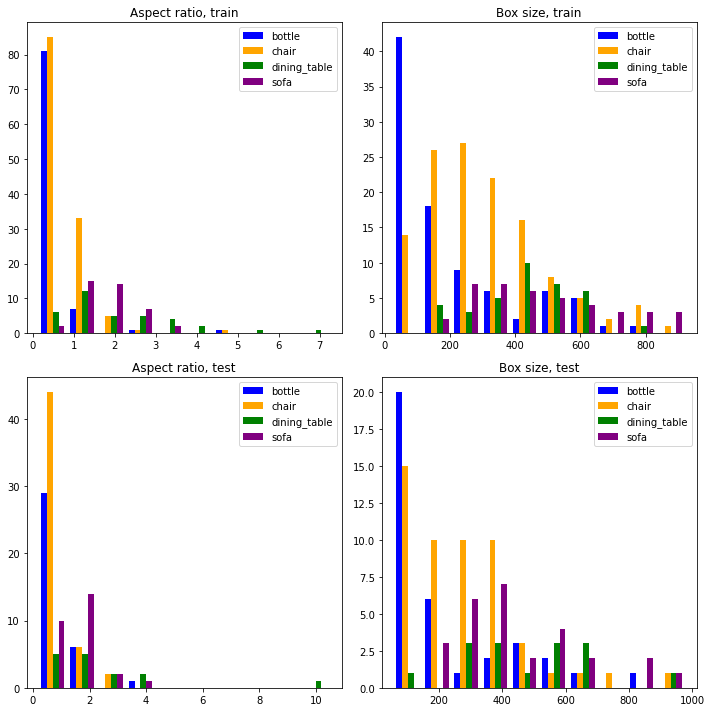

In [ ]:
# TRAIN
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ar, labels, size_anchors = get_gt_anchors(data_loader_0)

ax0, ax1, ax2, ax3 = axes.flatten()

ax0.set_title('Aspect ratio, train')
ax1.set_title('Box size, train')

ax0.hist(
    [ar[np.where(labels==1)[0]],
     ar[np.where(labels==2)[0]],
     ar[np.where(labels==3)[0]],
     ar[np.where(labels==4)[0]]],
    color=['blue','orange','green','purple'],
    label=class_names[1:]
)
ax1.hist(
    [size_anchors[np.where(labels==1)[0]],
     size_anchors[np.where(labels==2)[0]],
     size_anchors[np.where(labels==3)[0]],
     size_anchors[np.where(labels==4)[0]]],
    color=['blue','orange','green','purple'],
    label=class_names[1:]
)
ax0.legend(prop={'size': 10})
ax1.legend(prop={'size': 10})

# TEST
ar, labels, size_anchors = get_gt_anchors(data_loader_test_0)

ax2.set_title('Aspect ratio, test')
ax3.set_title('Box size, test')

ax2.hist(
    [ar[np.where(labels==1)[0]],
     ar[np.where(labels==2)[0]],
     ar[np.where(labels==3)[0]],
     ar[np.where(labels==4)[0]]],
    color=['blue','orange','green','purple'],
    label=class_names[1:]
)
ax3.hist(
    [size_anchors[np.where(labels==1)[0]],
     size_anchors[np.where(labels==2)[0]],
     size_anchors[np.where(labels==3)[0]],
     size_anchors[np.where(labels==4)[0]]],
    color=['blue','orange','green','purple'],
    label=class_names[1:]
)
ax2.legend(prop={'size': 10})
ax3.legend(prop={'size': 10})

fig.tight_layout()
plt.show()

The following one, on the other hand, calculates (once uncommented) the dsitribution of the anchors provided by the net.

In [ ]:
# Inference: extract the selected anchors
model_name = 'f-rcnn_obj0-5_iou0-5_e24.pth'
model_ft = load_model(f'{result_dir}/{model_name}')
results = test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5,
                               result_dir, False, False, False)

anchors, l_t = results['anchors'], results['l_t']


Evaluating...
Evaluation complete in 0m 40.14697265625s
Objectness-RPN. F1: 0.6551637511555771.     Precision: 0.5864197530864198. Recall: 0.7421652674674988
Global classification: F1: 0.9082727026496932.     Precision: 0.91875. Recall: 0.8980316742081449


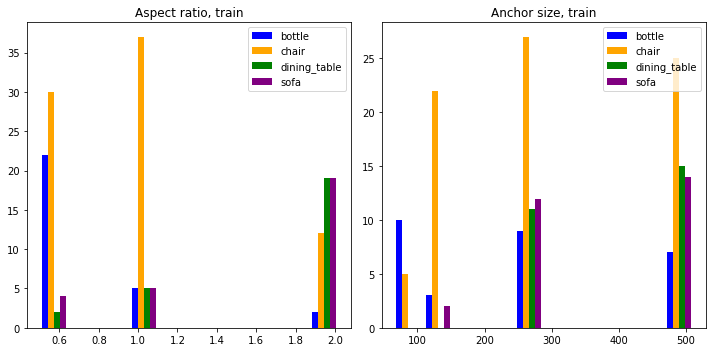

In [ ]:
# Anchor statistics
ar = []
labels = []
size_anchors = []
for i in range(anchors.shape[0]):
    labels.append(l_t[i])
    size_anchors.append(np.sqrt((anchors[i,2] - anchors[i,0]) * (anchors[i,3] - anchors[i,1])))
    ar.append((anchors[i,2] - anchors[i,0]) / (anchors[i,3] - anchors[i,1]))

ar = np.array(ar)
labels = np.array(labels)
size_anchors = np.array(size_anchors)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax0, ax1 = axes.flatten()

ax0.set_title('Aspect ratio, train')
ax1.set_title('Anchor size, train')

ax0.hist(
    [ar[np.where(labels==1)[0]],
     ar[np.where(labels==2)[0]],
     ar[np.where(labels==3)[0]],
     ar[np.where(labels==4)[0]]],
     color=['blue', 'orange', 'green', 'purple'],
    label=class_names[1:]
)
ax1.hist(
    [size_anchors[np.where(labels==1)[0]],
     size_anchors[np.where(labels==2)[0]],
     size_anchors[np.where(labels==3)[0]],
     size_anchors[np.where(labels==4)[0]]],
    color=['blue', 'orange', 'green', 'purple'],
    label=class_names[1:]
)
ax0.legend(prop={'size': 10})
ax1.legend(prop={'size': 10})

fig.tight_layout()
plt.show()

Is the distribution of the anchors' sizes and shapes related to those of the bounding boxes provided in training and testing? Justify your answer.

>Observing the previous results, we think they are related. This makes sense, as the anchors sizes and shapes represent predefined landmarks for bounding boxes to pick and use offsets to give location for detected object. This leads to the final bounding boxes distribution being slighty different from the original one, being this difference dependent on the anchors distribution, thus related.

After analyzing these results, why do you think the library changes the size of the images when these are fed to the network?

> When fed to the network, our images will be stacked and transformed to a single tensor input with one extra dimension. This cannot be done between images of different shapes, because the network cannot know the "alignment" between them, so their size needs to be reshaped. 

> Moreover, kernels may have been trained to a specific set of aspect ratios and thus the anchors of the features they extract are usually of a certain size. This can be seen in the previous graphs, where both  aspect ratios and anchor sizes distribution are mainly selected in 3 groups. 

Provide a brief analysis of the visual output of the net, the anchors and the bounding boxes obtained through regression for a given image (you can choose it randomly). Note that theses outputs should already be generated within the execution directory.

In [ ]:
results = test_detection_model(model_ft, data_loader_test, class_names,
                               0.7, 0.3, result_dir, True, True, False)


Evaluating...
Evaluation complete in 0m 38.37067723274231s
Objectness-RPN. F1: 0.757776100001551.     Precision: 0.8411214953271028. Recall: 0.6894587278366089
Global classification: F1: 0.9300373342767765.     Precision: 0.9493589743589743. Recall: 0.9114864864864866


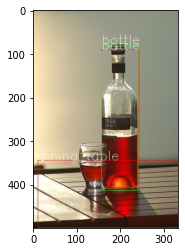

In [ ]:
from skimage import io

image = io.imread(f'{result_dir}/instances_pred_full/2009_000201.jpg')

plt.imshow(image)
plt.show()

> Answer here

Are the identified anchors satisfactory? Justify your answer.


Most of the anchors are generally satisfactory.

 How could we deal with an excessively low detection rate (unidentified objects in most of the images)?

> This excessively low detection rate would be defined by the global F1 score, which is obtained from the **precision and  recall metrics**. In order to determine the best approach, we think these two metrics should be analyzed separatedly for the **Region Proposal Network** and for the **final output** of the RCNN. 

> If the recall of the RPN was high and low for the RCNN output, probably we would need **more positive labels** for the network to learn. 

> If the other way around is the case, we might not have **enough amount of training data and less number of classes**. 

> When both are low, we would probably need to deal with some kind of image augmentation in order to enlarge our dataset. 

> Anyway, to fix this issue we could try testing the performance when modifying the **learning rate** or using multiple, different aspect ratios -similar to our original ones- so we could **get more labels** for training.

Doess regression work well for all cases? Does it work better for larger or smaller objects? Why do you think that happens?

> The 𝐿𝑟𝑒𝑔 loss function  considers the difference between the real bounding box and the anchors, thus minimizing the difference with ground truth regardless of the type of object. For calculating the targets for the regression, we use the foreground anchor and the closest ground truth object and calculate the correct Δ needed to transform the anchor into the object.

> Therefore, we believe that it detects small objects better because their **bounding boxes are more unlikely to overlap each other**. On the other hand, the boxes of large objects tend to overlap more between them and some small ones within these large ones. Thus, for small objects predicting objectness should be way faster and easier than predicting the class.

### 4. _RoI pooling_ and classification.

In this section, a visual representation of the *RoI pooling* outputs for the different classes will be obtained using the external function `visualize_roipooling`. Furthermore, the classification results will be analyzed. Uncomment the next cell to perform the analysis.

In the following code cell, visual representations of the *RoI pooling* are extracted for each object detected in the `roipool` folder, inside the results folder. The *RoI pooling* outputs a feature map $F_r$ of size $HxWxC = 7x7x2048$. Each representation, in turn, corresponds to a 7x7 cell in which the maximum value of this map $F_r$ is represented over all channels (that is, each element contains the maximum value of all channels for each cell). In this way, the spatial distribution of the activations in the *RoI pooling* can be inferred. Run the following cell and analyze the output representations.

__IMPORTANT__: the mean is not used to extract the representations since in convolutional networks most of the values ​​of the channels in a certain position are usually very low, and this makes the mean values ​​are very similar.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from external import visualize_roipooling

result_dir = 'baseline_results'
model_ft = load_model(f'{result_dir}/f-rcnn_obj0-5_iou0-5_e24.pth')

# For the roi-pooling experiment, analyze the top bounding-boxes (th_score > 0.7)
# and only those with th_iou > 0.7 with the ground-truth
visualize_roipooling(model_ft, data_loader_test, device, class_names, 0.7, 0.7, result_dir, True)

# For the confusion matrix, experiment with the standard thresholds
results = test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, False, False, True)

Evaluating...

Evaluating...
Evaluation complete in 0m 37.98782134056091s
Objectness-RPN. F1: 0.6551637511555771.     Precision: 0.5864197530864198. Recall: 0.7421652674674988
Class: bottle. Recall: 26/36
Class: chair. Recall: 34/52
Class: dining_table. Recall: 10/15
Class: sofa. Recall: 25/27

Global classification: F1: 0.9082727026496932.     Precision: 0.91875. Recall: 0.8980316742081449
Class: bottle F1: 0.9803921568627451.     Precision: 1.0. Recall: 0.9615384615384616
Class: chair F1: 0.8918918918918919.     Precision: 0.825. Recall: 0.9705882352941176
Class: dining_table F1: 0.9.     Precision: 0.9. Recall: 0.9
Class: sofa F1: 0.8444444444444444.     Precision: 0.95. Recall: 0.76


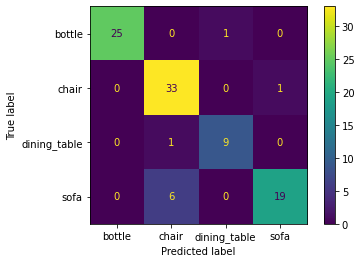

In [ ]:
dconf = ConfusionMatrixDisplay(results['cm'], display_labels=class_names[1:])
dconf.plot()

Visualize the outputs provided by `visualize_roipooling` and focus on the objects that appear completely in the images. Can the class of the object be inferred from the spatial distribution of the RoI pooling regardless of its scale? Justify your answer.

> To perform this analysis, we will rely on a **visual approach**. We have decided to interpret the shape and distribution of pixels in the pools as measures to determine possible spatial correlations.

> The most obvious are the Roi pooling whose shape is elongated, tall and of very small width: in practically all the examples studied, these pools correspond to **bottles**.

> We found some discrepancy between those representing **sofas** and **tables**. The ratio between their height and width, in both, is usually a little less than 1. However, we believe that those that are larger and wider tend to be tables, while when they have a medium width and height they appear to be sofas.

> The pattern relating **chair** objects and their roi pools has been more difficult to identify. We have concluded that they tend to be pools higher than wider but defitenely shorter than bottles.

Analyze the confusion matrix. Which classes are easier to confuse? Why do you think this happens?

> Checking the confusion matrix, it is obvious that the classes that are easier to confuse are **sofa** and **chair**. This makes sense, from a perceptual perspective, as these are objects that share very similar features. 

> In addition, they are the two classes with the greatest similarity between their RoI Pooling pixel average shapes, which could be causing the model to misidentify their labels. 